# Project 4: Higher Order Methods (Runge-Kutta, Symplectic, etc.)
## Abstract
In this lab, we computed the orbit of an asteroid under the influence of the Sun and Jupiter. We used the RK4 and Verlet algorithm to investigate the long term conservation of energy for both algorithms. The result gotten from the analysis is that the RK4 analysis doesn't conserve energy over long time periods although it is accurate over short term periods while the Verlet algorithm conserves energy over long time periods. Hence, Rk4 is a non-symplectic algorithm and Verlet is a symplectic algorithm over long time periods.
## Algorithm and Discussion
Runge–Kutta methods are a family of implicit and explicit iterative methods, which include the well-known routine called the Euler Method, used in temporal discretization for the approximate solutions of ordinary differential equations. An Rk4 algorithm can be seen below:

    def RK4Step(s, dt, t, derivs):
            f1 = derivs(s, t)*dt
            f2 = derivs(s+f1/2.0, t+dt/2.0)*dt
            f3 = derivs(s+f2/2.0, t+dt/2.0)*dt
            f4 = derivs(s+f3, t+dt)*dt
            return s + (f1+2*f2+2*f3+f4)/6.0
            
The Runge-Kutta method finds approximate value of y for a given x. Only first order ordinary differential equations can be solved by using the Runge Kutta 4th order method. The formula basically computes next value $y_{n+1}$ using current $y_{n}$ plus weighted average of four increments. $f_1$ is the increment based on the slope at the beginning of the interval, using s. $f_2$ is the increment based on the slope at the midpoint of the interval, using $s + \frac{f_1}{2}$. $f_3$ is again the increment based on the slope at the midpoint, using using $s + \frac{f_2}{2}$. $f_4$ is the increment based on the slope at the end of the interval, using $s + f_3$. The method is a fourth-order method, meaning that the local truncation error is on the order of $O(dt^5)$, while the total accumulated error is order $O(dt^4)$.

Although the Runge-kutta method can be accurate over short time periods, it is not accurate and doesn't conserve energy and other quantities over long time periods. There are systems that conserve energy over long term periods and they deem the runge-kutta analysis, unsatisfactory. These are called "Hamiltonian" systems due to the extensive history of applying the Hamiltonian (Energy oriented) formalism to their solution. The RK algorithms focus on reducing trucation error, but do not respect any inherantly conserved quantities. These Hamiltonian sytems or symplectic methods are designed to exactly conserve these quantities at the possible expense of some truncation error. The simplest of these is the SymplecticEuler method (sometimes knows as the Cromer method). A second order version is the Verlet method, or the "Leapfrog" method.

    def EulerStep(s, t, derivs, dt):
        return s + derivs(s,t)*dt

    def SymplecticEulerStep(s, t, derivs, dt):
        s1 = s + derivs(s,t,0)*dt     #  q-step
        return s1 + derivs(s1,t,1)*dt #  p-step

    def VerletStep(s, t, derivs, dt):
        dth = dt/2.0  # half of h
        s = s + derivs(s, t, 0)*dth       # changes only positon
        s = s + derivs(s, t+dth, 1)*dt    # changes only velocity
        return s + derivs(s, t+dt, 0)*dth # change only position
        
SymplecticEulerStep and VerletStep methods add a third argument when they call derivs. This argument tells the derivs function whether the step is a "space step, or q-step" (pass a zero) or a "velocity step, or p-step" (pass a one). If the derivs function detects that a third argument has been passed it should return zero in the rate of change of the "other" part of the state (e.g., if it's a "space step" then the rate of change of the velocity (or momentum) should be zero). In this way the VerletStep function can carefully craft a sequence of steps that take care to conserve area in phase space (and energy in the long run, even though they may be less accurate in the short run).

## Implementation and Code
This half of the code just shows and defines the symplectic and non-symplectic algorithms with are the Verlet and Rk4 algorithms respectively.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as pl 
import numpy as np

G = (2*np.pi)**2   # measure time in years, distance in AU
Ms = 1.0        # mass in solar masses
Mj = Ms/1047    # jupiter's mass is much less than the Sun's
Ma = Mj/1e7     # typical asteroid mass.. *really* small.
GMs = G*Ms      # save multiplying later ...
GMj = G*Mj
GMa = G*Ma

def RK4Step(s, t, derivs, dt):
    dth=dt/2.0
    f1 = derivs(s, t)
    f2 = derivs(s+f1*dth, t+dth)
    f3 = derivs(s+f2*dth, t+dth)
    f4 = derivs(s+f3*dt, t+dt)
    return s + (f1+2*f2+2*f3+f4)*dt/6.0

def VerletStep(s, t, derivs, dt):
    dth = dt/2.0  # half of h
    s = s + derivs(s, t, 0)*dth       # changes only positon
    s = s + derivs(s, t + dth, 1)*dt    # changes only velocity from s1
    return s + derivs(s, t + dt, 0)*dth # change only position

def derivs_grav(s, t, step = None):
    """
    Compute motion of asteriod and Jupiter about the Sun
    """
    rsa = s[:2]  # position of asteroid relative to sun
    rsj = s[2:4] # for symplectic integrators it's handy to have all r's together
    va = s[4:6]  # followed by all v's in the state array.
    vj = s[6:8]  
    rja = rsa - rsj
    
    rsjm3 = (rsj * rsj).sum()**(1.5)  # compute |r_{sj}|**3 for vector force calculation
    rsam3 = (rsa * rsa).sum()**(1.5)  # similar for r_{sa}
    rjam3 = (rja * rja).sum()**(1.5)  # similar for r_{ja}
    
    aj = -(GMs*rsj/rsjm3 - GMa*rja/rjam3)
    aa = -(GMs*rsa/rsam3 + GMj*rja/rjam3)
    
    if step == 0:
        return np.array([va[0], va[1], vj[0], vj[1], 0, 0, 0, 0])
    
    if step == 1:
        return np.array([0, 0, 0, 0, aa[0], aa[1], aj[0], aj[1]])
    
    else:
         return np.array([va[0], va[1], vj[0], vj[1], aa[0], aa[1], aj[0], aj[1]])
        
    
    

The energy of this system is the kinetic energies of Jupiter and the asteroids, potential energies of Jupiter, asteroids, and the sun among themselves i.e. between the sun and Jupiter, sun and the asteroids and the asteroids and Jupiter.

$$E = Kinetic_{Jupiter} + Kinetic_{Asteroids} + Potential_{Sun -> Jupiter} + Potential_{Asteroids -> Jupiter} + Potential_{Sun -> Asteroids}$$

In [2]:
def Energy(s):
    kinetic_a = 0.5 * Ma  * (s[4]**2 + s[5]**2)
    kinetic_j = 0.5 * Mj  * (s[6]**2 + s[7]**2)
    Potential_a = -(G * Ms * Ma)/np.sqrt(s[1]**2 + s[0]**2)
    Potential_j = -(G * Ms * Mj)/np.sqrt(s[2]**2 + s[3]**2)
    Potential_aj = -((G * Mj * Ma)/(np.sqrt(((s[0] - s[2])**2)+ ((s[1] - s[3])**2))))
    return (kinetic_a + kinetic_j +  Potential_a + Potential_j + Potential_aj)

We would be applying the Runge-Kutta Method, first, to compute the orbit of an asteroid under the influence of the Sun and Jupiter. Keeping track of the energy, distance from the sun to the asteroid, distance from the sun to Jupiter, and the velocity of the asteroid and Jupiter. Knowing that Runge-kutta isn't symplectic, i defined a boolean function, "DoSymplectic", and set it to false if we are not computing a symplectic function. This computed the orbit using the Runge-Kutta method.

C:\Users\david\Anaconda32\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


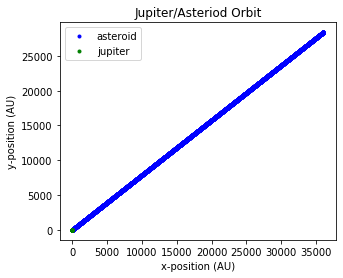

In [3]:
Rj=5.2     # AU
Ra=3.0     # AU

s = np.array([Ra,0,Rj,0,0,np.sqrt(GMs/Ra),0,np.sqrt(GMs/Rj)])  # assume circular orbits
Do_symplectic = False
xalist=[]  # empty lists
yalist=[]
tlist=[]
xjlist=[]
yjlist=[]
erlist=[]  # RK4 Energies

t=0.0
dt=0.3

while t < 3000:
    if Do_symplectic:
        s = VerletStep(s, t, derivs_grav, dt)
    else:    
        s = RK4Step(s, t, derivs_grav, dt)
    t+=dt
    tlist.append(t)
    xalist.append(s[0])
    yalist.append(s[1])
    xjlist.append(s[2])
    yjlist.append(s[3])
    erlist.append(Energy(s))
    
pl.title("Jupiter/Asteriod Orbit")
pl.xlabel("x-position (AU)")
pl.ylabel("y-position (AU)")
pl.axes().set_aspect('equal')

pl.plot(xalist, yalist,'b.',label="asteroid")
pl.plot(xjlist, yjlist,'g.',label="jupiter")
pl.legend()

At a time step of 3000 years, we can see a straight line graph. This potrays the fact that although the Rk4 algorithm helps truncate errors over short time periods, on the long run it doesn't take into account nor does it regard conservation of energy. Over a short period of time, the graph would produce an orbital diagram.

Changing the Boolean value to "True" and calling for the Verlet function to be implemented over the same time period we want to see what happens:

C:\Users\david\Anaconda32\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


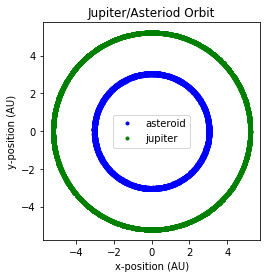

In [4]:
Rj=5.2     # AU
Ra=3.0     # AU

s = np.array([Ra,0,Rj,0,0,np.sqrt(GMs/Ra),0,np.sqrt(GMs/Rj)])  # assume circular orbits
Do_symplectic = True
xalist=[]  # empty lists
yalist=[]
tlist=[]
xjlist=[]
yjlist=[]
evlist=[]  # Verlet Energies

t=0.0
dt=0.3

while t < 3000:
    if Do_symplectic:
        s = VerletStep(s, t, derivs_grav, dt)
    else:    
        s = RK4Step(s, t, derivs_grav, dt)
    t+=dt
    tlist.append(t)
    xalist.append(s[0])
    yalist.append(s[1])
    xjlist.append(s[2])
    yjlist.append(s[3])
    evlist.append(Energy(s))
pl.title("Jupiter/Asteriod Orbit")
pl.xlabel("x-position (AU)")
pl.ylabel("y-position (AU)")
pl.axes().set_aspect('equal')

pl.plot(xalist, yalist,'b.',label="asteroid")
pl.plot(xjlist, yjlist,'g.',label="jupiter")
pl.legend()

We can see that over the long run, the Verlet algorithm conserved energy. The orbital diagram proves that as there's no change in surface area of orbit over time. We can plot the energy diagrams of the different algorithms and see in the graph below that as time passes, there is a drop in energy for the Rk4 algorithm and energy is constant for the Verlet algorithm. If we look closely, we can observe how narrow the Rk4 algorithm energy line is compared to the Verlet algorithm energy line this just shows that the Rk4 algorithm is more precise in energy conservations and orbital predictions over shorter time periods than the Verlet algorithm. This obervation also confirms Heisenberg's Principle of uncertainty which states that the position and the velocity of an object cannot both be measured exactly, at the same time, even in theory. Runge kutta's algorithm updates postion and velocity at the same time which gives an inaccurate prediction over the long run unlike the Verlet algorith which updates them one at a time.

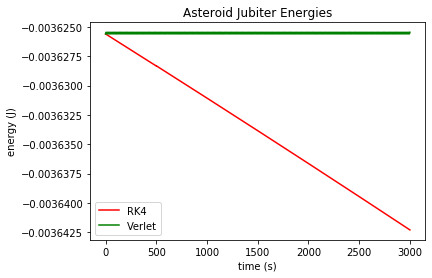

In [5]:
pl.title("Asteroid Jubiter Energies")
pl.xlabel("time (s)")
pl.ylabel("energy (J)")
pl.plot(tlist, erlist, 'r-', label="RK4")
pl.plot(tlist, evlist, 'g-', label="Verlet")
pl.legend(loc=3)

## Conclusion
 We used the RK4 and Verlet algorithm to investigate the long term conservation of energy for both algorithms. The result gotten from the analysis is that the RK4 analysis doesn't conserve energy over long time periods although it is accurate over short term periods while the Verlet algorithm conserves energy over long time periods. Hence, Rk4 is a non-symplectic algorithm and Verlet is a symplectic algorithm over long time periods. Runge kutta's algorithm updates postion and velocity at the same time which gives an inaccurate prediction over the long run unlike the Verlet algorith which updates them one at a time. This confirms Heisenberg principle of Uncertainty.